Dataset: 10,000 samples, 197 positives (2.0% prevalence)


2. High Recall
Low Precision – Catches nearly all positives
but many false alarms
    TP     FP     FN      TN
   197   1156      0    8647
Accuracy    : 0.8844
Precision   : 0.1456
Recall      : 1.0000
Specificity : 0.8821
F1-score    : 0.2542
F0.5-score  : 0.1756  ← favors precision
F2-score    : 0.4601  ← favors recall

3. High Precision
Low Recall – Very cautious predictor
misses many positives
    TP     FP     FN      TN
   172      0     25    9803
Accuracy    : 0.9975
Precision   : 1.0000
Recall      : 0.8731
Specificity : 1.0000
F1-score    : 0.9322
F0.5-score  : 0.9718  ← favors precision
F2-score    : 0.8958  ← favors recall

5. Good Balanced Model – Realistic strong model
low false positives
    TP     FP     FN      TN
   197    194      0    9609
Accuracy    : 0.9806
Precision   : 0.5038
Recall      : 1.0000
Specificity : 0.9802
F1-score    : 0.6701
F0.5-score  : 0.5593  ← favors precision
F2-score    : 0.8355  ← 

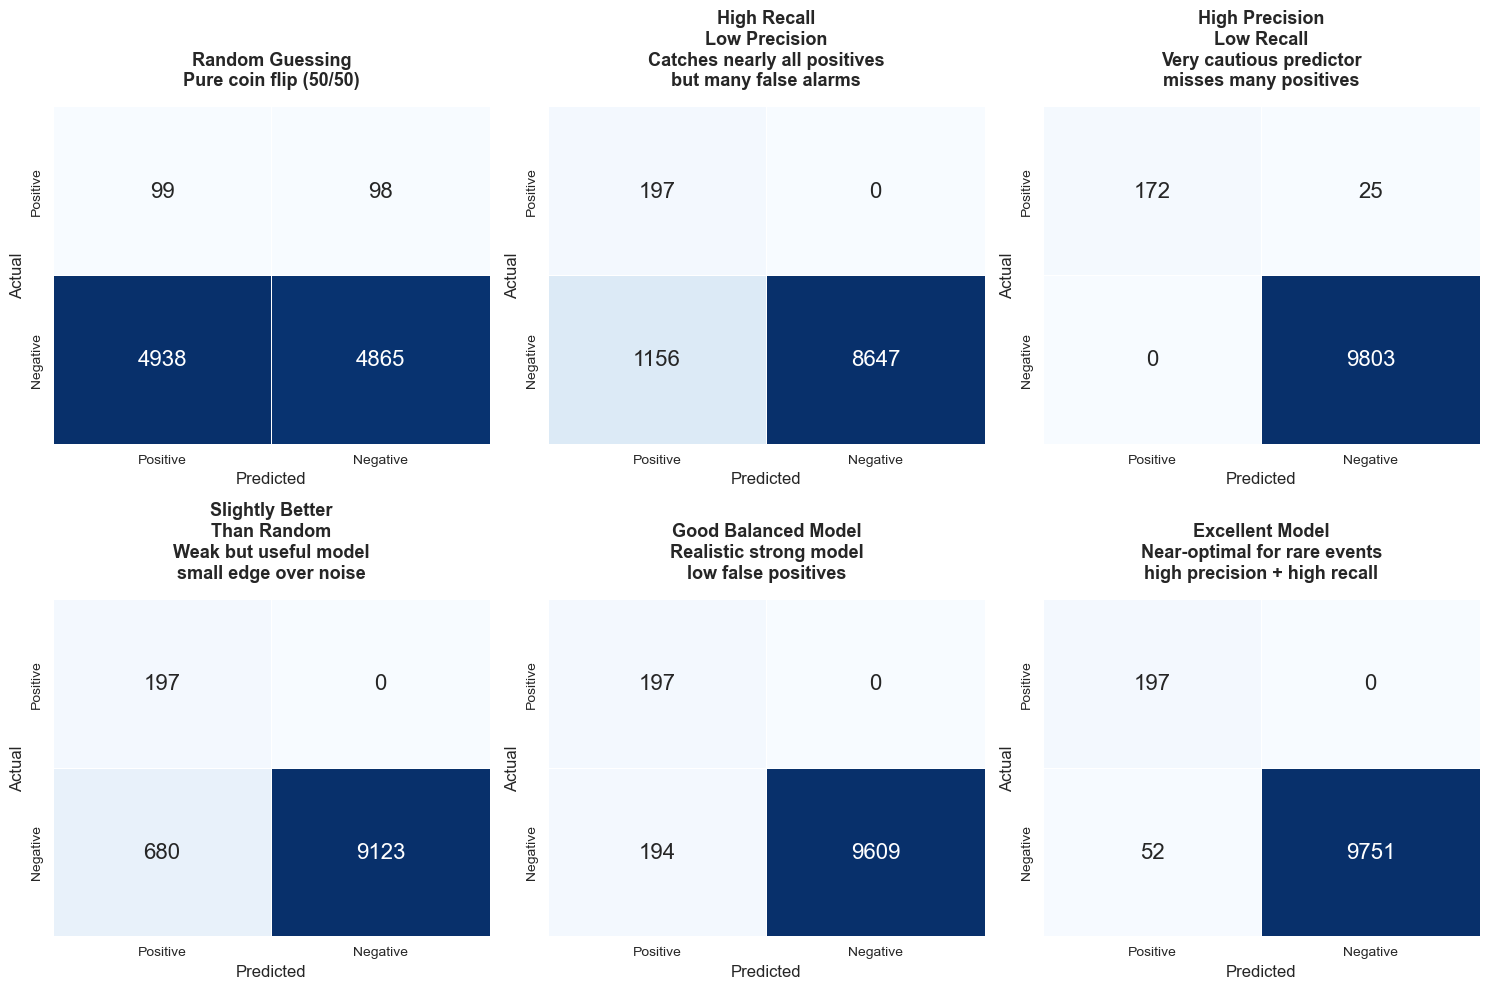


SUMMARY COMPARISON
                         Model   TP    FP   FN  Precision  Recall      F1  \
0              Random Guessing   89  4850  108     0.0180  0.4518  0.0347   
1    High Recall Low Precision  197  1121    0     0.1495  1.0000  0.2601   
2    High Precision Low Recall  161     0   36     1.0000  0.8173  0.8994   
3  Slightly Better Than Random  197   684    0     0.2236  1.0000  0.3655   
4          Good Balanced Model  197   186    0     0.5144  1.0000  0.6793   
5              Excellent Model  197    45    0     0.8140  1.0000  0.8975   

     F0.5      F2  Accuracy  
0  0.0223  0.0777    0.5042  
1  0.1801  0.4677    0.8879  
2  0.9572  0.8483    0.9964  
3  0.2647  0.5902    0.9316  
4  0.5697  0.8412    0.9814  
5  0.8455  0.9563    0.9955  


In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Nice styling
sns.set_style("white")
sns.set_palette("husl")

def fbeta_score(precision, recall, beta=1.0):
    if precision == 0 and recall == 0:
        return 0.0
    return (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall + 1e-12)

def print_metrics(y_true, y_pred, title=""):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = f1_score(y_true, y_pred, zero_division=0)
    f05 = fbeta_score(precision, recall, beta=0.5)
    f2 = fbeta_score(precision, recall, beta=2.0)
    
    print(f"\n{title}")
    print(f"{'TP':>6} {'FP':>6} {'FN':>6} {'TN':>7}")
    print(f"{tp:6d} {fp:6d} {fn:6d} {tn:7d}")
    print(f"Accuracy    : {accuracy:.4f}")
    print(f"Precision   : {precision:.4f}")
    print(f"Recall      : {recall:.4f}")
    print(f"Specificity : {specificity:.4f}")
    print(f"F1-score    : {f1:.4f}")
    print(f"F0.5-score  : {f05:.4f}  ← favors precision")
    print(f"F2-score    : {f2:.4f}  ← favors recall")

def plot_confusion_matrix(y_true, y_pred, title="", ax=None):
    cm = confusion_matrix(y_true, y_pred)
    # Reorder to: Positive first (top/left)
    cm_reordered = np.array([[cm[1,1], cm[1,0]],   # TP, FN
                             [cm[0,1], cm[0,0]]])  # FP, TN
    
    labels = ['Positive', 'Negative']
    sns.heatmap(cm_reordered, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Positive', 'Negative'],
                yticklabels=['Positive', 'Negative'],
                annot_kws={"size": 16}, linewidths=0.5, ax=ax)
    
    ax.set_title(title, fontsize=13, pad=15, weight='bold')
    ax.set_ylabel('Actual', fontsize=12)
    ax.set_xlabel('Predicted', fontsize=12)

# =============================================================================
# Generate realistic examples (rare events: ~2% positive prevalence)
# =============================================================================

np.random.seed(42)
n_samples = 10_000
prevalence = 0.02
y_true = np.random.choice([1, 0], size=n_samples, p=[prevalence, 1 - prevalence])
n_positives = y_true.sum()

examples = [
    ("Random Guessing", "Pure coin flip (50/50)", 
     lambda y: np.random.randint(0, 2, size=len(y))),
    
    ("High Recall\nLow Precision", "Catches nearly all positives\nbut many false alarms", 
     lambda y: (y == 1) | (np.random.random(len(y)) < 0.12)),
    
    ("High Precision\nLow Recall", "Very cautious predictor\nmisses many positives", 
     lambda y: (y == 1) & (np.random.random(len(y)) < 0.85)),  # only predicts pos when very sure
    
    ("Slightly Better\nThan Random", "Weak but useful model\nsmall edge over noise", 
     lambda y: y | (np.random.random(len(y)) < 0.07)),
    
    ("Good Balanced Model", "Realistic strong model\nlow false positives", 
     lambda y: (y == 1) | ((y == 0) & (np.random.random(len(y)) < 0.018))),
    
    ("Excellent Model", "Near-optimal for rare events\nhigh precision + high recall", 
     lambda y: (y == 1) | ((y == 0) & (np.random.random(len(y)) < 0.005))),
]

# =============================================================================
# Plot 2x3 grid
# =============================================================================

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

print(f"Dataset: {n_samples:,} samples, {n_positives} positives ({prevalence:.1%} prevalence)\n")
print("="*85)

for i, (name, desc, pred_func) in enumerate(examples):
    y_pred = pred_func(y_true).astype(int)
    plot_confusion_matrix(y_true, y_pred, title=f"{name}\n{desc}", ax=axes[i])
    
    # Print metrics for the most interesting ones
    if i in [1, 2, 4, 5]:  # High Recall, High Prec, Good, Excellent
        print_metrics(y_true, y_pred, title=f"{i+1}. {name} – {desc}")

plt.tight_layout()
plt.show()

# =============================================================================
# Summary comparison table
# =============================================================================

results = []
for name, _, pred_func in examples:
    y_pred = pred_func(y_true).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    results.append({
        'Model': name.replace('\n', ' '),
        'TP': tp,
        'FP': fp,
        'FN': fn,
        'Precision': precision,
        'Recall': recall,
        'F1': f1_score(y_true, y_pred, zero_division=0),
        'F0.5': fbeta_score(precision, recall, 0.5),
        'F2': fbeta_score(precision, recall, 2.0),
        'Accuracy': accuracy_score(y_true, y_pred),
    })

df = pd.DataFrame(results)
print("\nSUMMARY COMPARISON")
print("="*100)
print(df[['Model', 'TP', 'FP', 'FN', 'Precision', 'Recall', 'F1', 'F0.5', 'F2', 'Accuracy']].round(4))